# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [3]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 0.00038431,      # volt
    f = 20,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,0.000384
f,20.000000
vin,0.000000


In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [5]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,0.00038431
f,20
init,V_out 0 dtype: int64
t_end,0.2
ts,"[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0...."
omega,125.664
tau,0.0049
cutoff,32.4806


In [37]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [38]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [8]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

In [9]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.0000 0.000000 0.0005 0.000037 0.0010 ...


In [10]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,0.00038431
f,20
init,V_out 0 dtype: int64
t_end,0.2
ts,"[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0...."
omega,125.664
tau,0.1
cutoff,1.59155


In [11]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = ((vin(t) - vout) * (system.R * system.C * system.omega)) / (system.R * system.C)
    
    return dvoutdt

In [12]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [13]:
results2, details2 = run_ode_solver(system2, slope_func_high_pass, t_eval=system2.ts)

In [14]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.0000 0.000000 0.0005 0.000001 0.0010 ...


In [15]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,0.00038431
f,20
init,V_out 0 dtype: int64
t_end,0.2
ts,"[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0...."
omega,125.664
tau,0.00499
cutoff,31.8948


In [16]:
results3, details3 = run_ode_solver(system3, slope_func_low_pass, t_eval=system3.ts)

In [17]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.0000 0.000000e+00 0.0005 5.141369e-08 ...


In [18]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,0.00038431
f,20
init,V_out 0 dtype: int64
t_end,0.2
ts,"[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0...."
omega,125.664
tau,0.0049
cutoff,32.4806


In [19]:
results4, details4 = run_ode_solver(system4, slope_func_low_pass, t_eval=system4.ts)

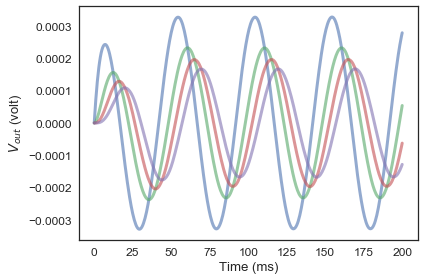

In [20]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

In [69]:
def vin_signal(system):
    """Find line of best fit for data to show the general trend over time.
    
    returns: A TimeSeries with corresponding values that are outputs of the function
    """
    unpack(system)
    
    func = TimeSeries()
    #for loop is used to determine the values of the function at each corresponding x value.
    for t in (0, 200):
        v = A * np.cos(2 * pi * f * ts)
        func[t] = v
    return v

In [70]:
sig = vin_signal(params1);

In [73]:
vin_sig = pd.DataFrame({'time':system1.ts * 1000,
                        'V_out':sig})
vin_sig.set_index('time')

,V_out
time,
0.0,3.843100e-04
0.5,3.835517e-04
1.0,3.812796e-04
1.5,3.775028e-04
2.0,3.722362e-04
2.5,3.655005e-04
3.0,3.573224e-04
3.5,3.477341e-04
4.0,3.367734e-04


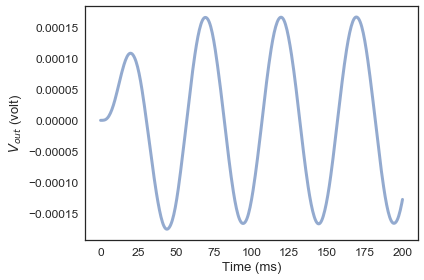

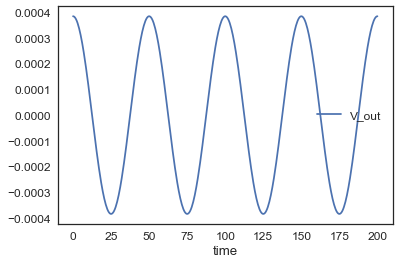

In [74]:
plot_results(results4)
#plot_results(vin_sig)
vin_sig.plot('time','V_out')

In [21]:
amp_params = Params(
    R1 = 2e3,
    R2 = 4.9e3,
    vin = results4.V_out)

,values
R1,2000
R2,4900
vin,0.0000 0.000000e+00 0.0005 1.952458e-09 ...


In [22]:
def make_system_amp(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    ts = linspace(0, t_end, 401)
    
    return System(R1=R1, R2=R2, 
                  init=init, ts=ts, vin=vin)

In [23]:
total_amp = make_system_amp(amp_params)

,values
R1,2000
R2,4900
init,V_out 0 dtype: int64
ts,"[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0...."
vin,0.0000 0.000000e+00 0.0005 1.952458e-09 ...


In [24]:
def amp(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin = system.vin
    
    G1 = 1 + (100e3 / R1)
    G2 = 1 + (100e3 / R2)

    vout = vin * G1 * G2
    
    return vout

In [25]:
results_amp_1 = amp(total_amp, total_amp.ts, total_amp);

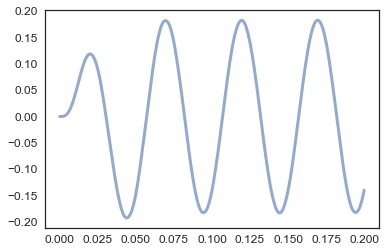

In [26]:
plot(results_amp_1)